In [48]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import datetime
import mplfinance as mpf
import numpy as np
import datetime
import requests
import pandas as pd
import datetime
from tensorflow.keras.models import load_model



               time          open    close     high           low  \
0     1556668800000   5599.522730   5619.1   5655.0   5589.720065   
1     1556683200000   5619.100000   5624.9   5629.7   5615.700000   
2     1556697600000   5624.900000   5625.3   5630.0   5613.800000   
3     1556712000000   5625.372199   5608.6   5625.5   5594.200000   
4     1556726400000   5608.600000   5603.9   5629.6   5577.500000   
...             ...           ...      ...      ...           ...   
9026  1686657600000  26217.000000  25780.0  26455.0  25744.000000   
9027  1686672000000  25771.000000  25905.0  25989.0  25761.000000   
9028  1686686400000  25914.000000  25948.0  25977.0  25836.000000   
9029  1686700800000  25953.000000  26003.0  26066.0  25930.000000   
9030  1686715200000  26001.000000  25904.0  26017.0  25857.000000   

           volume        date  
0     1294.574369  2019-05-01  
1      739.693383  2019-05-01  
2      870.122931  2019-05-01  
3      928.865078  2019-05-01  
4     1323.

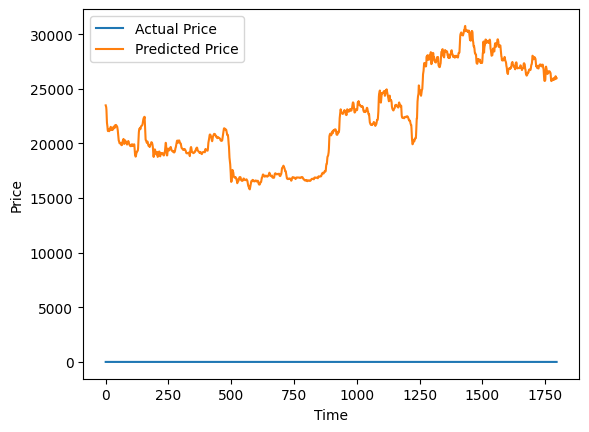

In [49]:


# API 엔드포인트
endpoint = 'https://api-pub.bitfinex.com/v2/candles/trade:4h:tBTCUSD/hist'

# 시작 날짜 설정 (YYYY-MM-DD 형식)
start_date = '2019-05-01'

# 시작 날짜를 Unix 타임스탬프로 변환
start_timestamp = pd.to_datetime(start_date).timestamp() * 1000  # 밀리초 단위로 변환

# 요청 파라미터 설정
params = {
    'limit': 10000,  # 받아올 데이터 개수
    'sort': 1,  # 오름차순 정렬
}

# API 호출을 위한 함수 정의
def fetch_bitfinex_data(start_timestamp):
    params['start'] = int(start_timestamp)
    response = requests.get(endpoint, params=params)
    data = response.json()
    df = pd.DataFrame(data, columns=['time', 'open', 'close', 'high', 'low', 'volume'])
    df['date'] = pd.to_datetime(df['time'], unit='ms').dt.date  # 날짜 열 추가
    return df

# 데이터 불러오기
df = fetch_bitfinex_data(start_timestamp)
print(df)

# 데이터 전처리
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 결측치 처리
df['previous_close'] = df['close'].fillna(df['close'].shift(1) + df['close'].shift(-1)) / 2

# 데이터 정렬
df.sort_index(ascending=True, inplace=True)

# 입력 데이터 및 타겟 데이터 생성
input_features = ['close', 'open', 'high', 'low', 'volume']
target_feature = 'close'

X = df[input_features].values
y = df[target_feature].values

# 데이터 스케일링
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

# 학습 및 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

# 데이터 형태 변환 (3D 형식으로)
timesteps = 10  # 시계열 데이터의 길이 설정
X_train_3D = []
X_test_3D = []

for i in range(timesteps, len(X_train)):
    X_train_3D.append(X_train[i - timesteps:i])
X_train_3D = np.array(X_train_3D)

for i in range(timesteps, len(X_test)):
    X_test_3D.append(X_test[i - timesteps:i])
X_test_3D = np.array(X_test_3D)

# LSTM 모델 생성
model = Sequential()
model.add(LSTM(64, input_shape=(X_train_3D.shape[1], X_train_3D.shape[2]), activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))

# 모델 컴파일
model.compile(loss=Huber(), optimizer=Adam(learning_rate=0.001))

# 조기 종료 및 모델 체크포인트 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint('bitcoin_model.h5', monitor='val_loss', save_best_only=True)


# 데이터 형태 변환 (3D 형식으로)
timesteps = 10  # 시계열 데이터의 길이 설정
X_train_3D = []
X_test_3D = []

for i in range(timesteps, len(X_train)):
    X_train_3D.append(X_train[i - timesteps:i])
X_train_3D = np.array(X_train_3D)
y_train = y_train[timesteps:]

for i in range(timesteps, len(X_test)):
    X_test_3D.append(X_test[i - timesteps:i])
X_test_3D = np.array(X_test_3D)
y_test = y_test[timesteps:]

# 모델 학습
history = model.fit(X_train_3D, y_train, epochs=50, batch_size=64, validation_data=(X_test_3D, y_test),
                    callbacks=[early_stopping, checkpoint])

# 예측 결과 시각화
plt.plot(y_test, label='Actual Price')
plt.plot(y_pred, label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [50]:
# 모델 로드
model = load_model('bitcoin_model.h5')

# 입력 데이터 생성
future_inputs = X[-timesteps:]
future_inputs_3D = np.expand_dims(future_inputs, axis=0)

# 가격 예측
predicted_prices = []
for _ in range(100):
    predicted_price = model.predict(future_inputs_3D)[0][0]  # 다음 가격 예측
    predicted_prices.append(predicted_price)
    future_inputs = np.concatenate([future_inputs[1:], np.expand_dims([predicted_price], axis=0)], axis=0)
    future_inputs_3D = np.expand_dims(future_inputs, axis=0)

# 예측 결과 출력
for i, price in enumerate(predicted_prices):
    print(f"시간: {i+1}, 예측 가격: {scaler.inverse_transform([[price]])[0][0]:.2f}")


1/1 [==============================] - 0s 233ms/step


ValueError: ignored